# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 07/24/2024 by AFS

In [6]:
import numpy as np
import pandas as pd
from glob import glob
from scipy.stats import t
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import matplotlib.pyplot as plt
import datetime
import seaborn as sns


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

07242024


In [3]:
# path to sample data 
#user_base_dir   = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/'
user_base_dir   = '/Users/christinamaher/Documents/GitHub/'
sample_data_dir = f'{user_base_dir}NeuroCluster/data/'


In [4]:
# load functions 
import sys
sys.path.append(f'{user_base_dir}NeuroCluster/scripts/')

from tfr_cluster_test import *
from helper_utils import *
from plotting_utils import * 

In [10]:
with open(f'{user_base_dir}NeuroCluster/requirements.txt') as f:
    required = f.read().splitlines()

In [11]:
required

['joblib==1.2.0',
 'matplotlib==3.6.3',
 'numpy==1.23.5',
 'pandas==1.5.3',
 'scipy==1.10.0',
 'statsmodels==0.13.5',
 'tqdm==4.64.1',
 'ipykernel==6.21.0',
 'ipywidgets==8.0.4',
 'ipython==8.12.3',
 'jupyter_client==8.0.2',
 'jupyter_core==5.2.0',
 'seaborn==0.13.2',
 'notebook']

# Step 1: Format input data (neural and behavioral)

- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [12]:
sample_ieeg_files = glob(f'{sample_data_dir}*.npy')
sample_ieeg_dict = {f'{file.split("/")[-1].split(".")[0]}':np.load(file) for file in sample_ieeg_files}
ieeg_channels = list(sample_ieeg_dict.keys())
sample_behav = pd.read_csv(f'{sample_data_dir}sample_behavior.csv')

In [13]:
# define regression predictor variables
multi_reg_vars = ['outcome','error']
# set main predictor of interest for permutations 
permute_var = 'error'
# subset input dataframe to include only multi_reg_vars
predictor_data = sample_behav.copy()[multi_reg_vars]

In [14]:
predictor_data

,outcome,error
0,bad,1.92
1,good,0.60
2,good,0.20
3,bad,-0.40
4,bad,0.52
...,...,...
145,bad,-0.30
146,bad,-1.04
147,good,-0.15
148,bad,0.40


# Step 2: Perform within-electrode cluster test.

First, let's create a variable called tfr_data which is a np.array (dimensions should correspond with number of trials x number of frequencies x number of timepoints)

In [15]:
# create tfr_data which is np.array of (num epochs x num frequencies x num times)
demo_channel = 'channel_13'
tfr_data = sample_ieeg_dict[demo_channel]
# check shape 
tfr_data.shape # dimensions correspond with trials, frequencies, timepoints

Next, let's create an instance of TFR_Cluster_Test. This will be used to run the cluster test. It requires the tfr_data, predictor_data, permute_var, and demo_channel as inputs.

In [17]:
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,demo_channel)
cluster_test

Now, we are reading to run our linear regression based on the dependent neural variable (`tfr_data`) and independent behavioral variables (`predictor_data`, `permute_var`) we passed as inputs to our `TFR_Cluster_Test` object. This will return pixel-level **β coefficients** and corresponding **t-statistics** for our TFR data in one electrode.

In [18]:
betas, tstats = cluster_test.tfr_regression()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 34824 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    4.5s finished


Let's plot the **β coefficients** to give us an idea of the neural encoding pattern for our continuous predictor of interest.

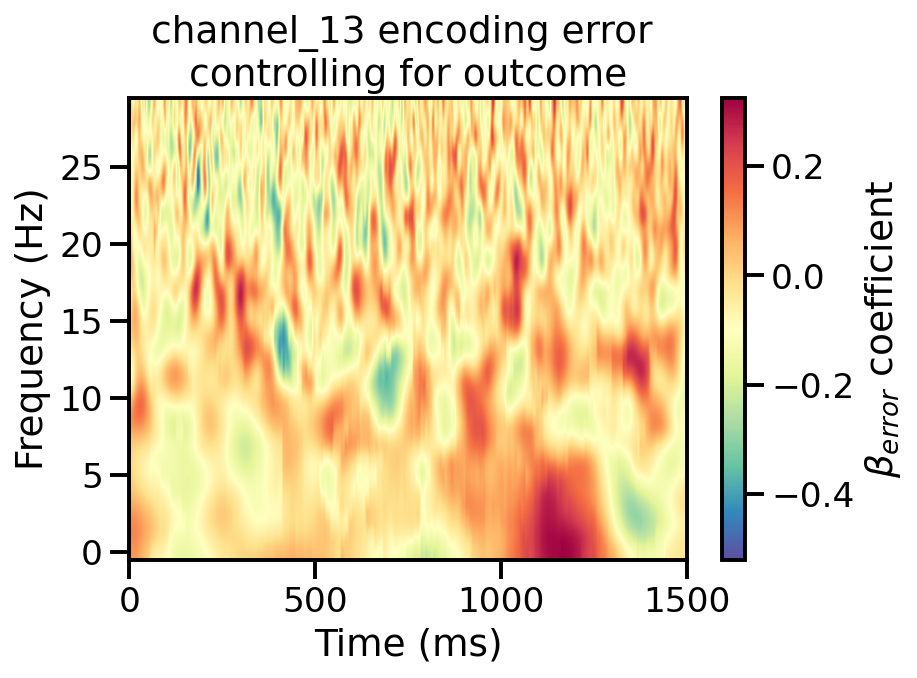

In [19]:
plot_beta_coef(betas,cluster_test,figsize=(6,4),dpi=150,sns_context='talk',cmap='Spectral_r')

We can also plot the **t-statistics** that correspond with the **β coefficient** for each time-frequency point.

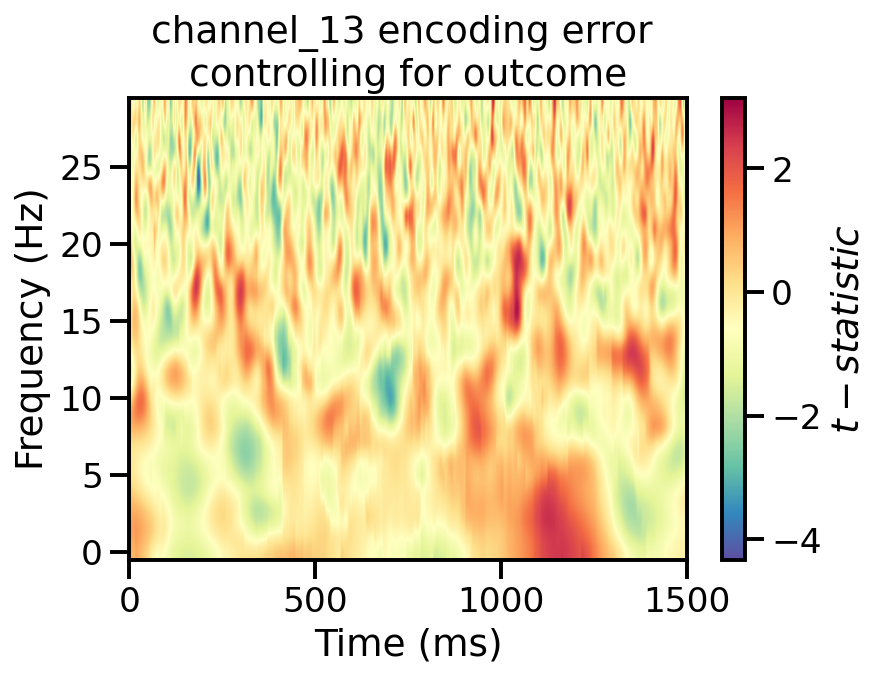

In [22]:
plot_tstats(tstats,cluster_test,figsize=(6,4),dpi=150,sns_context='talk',cmap='Spectral_r')

Let's highlight **clusters** (defined as consecutive time x frequency points) with significant t-statistics. We can do this separately for both positive and negative clusters. 

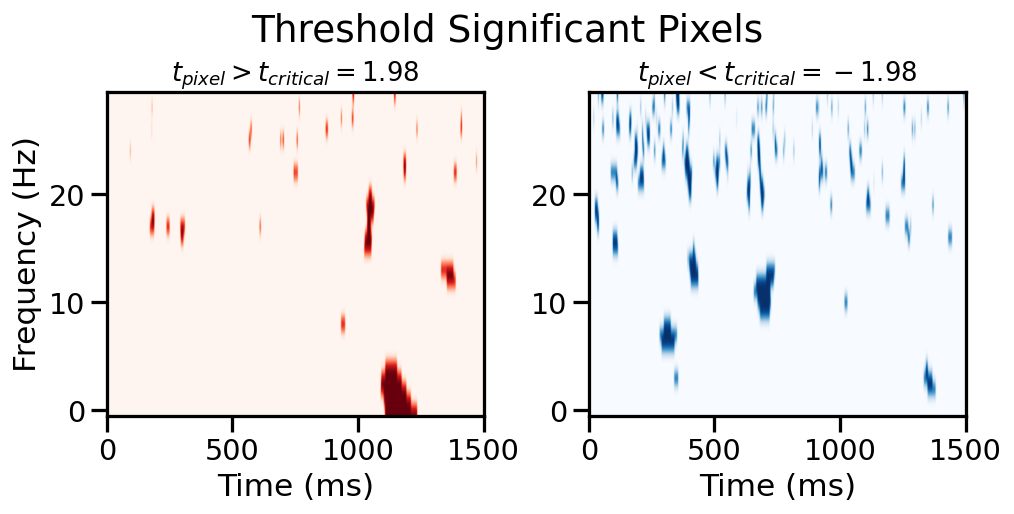

In [21]:
plot_clusters(tstats,cluster_test,figsize=(8,4),dpi=125,sns_context='talk')

Now, we will identify the largest cluster (either/both positive and negative) and save the **cluster statistic** which will be our test statistic against our non-parametric null distribution. `max_tfr_cluster()` returns a dictionary containing the **cluster statistic**:`cluster_stat` and its associated **freq_idx**: `freq_idx` and **time_idx**:`time_idx`.

In [25]:
# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all',alternative='two-sided')
print(f'Max positive cluster dictionary: {max_cluster_data[0]}')
print(f'Max negative cluster dictionary: {max_cluster_data[1]}')

Max positive cluster dictionary: {'cluster_stat': 1073.1570090060386, 'freq_idx': (0, 4), 'time_idx': (1087, 1231)}
Max negative cluster dictionary: {'cluster_stat': -671.9854694066082, 'freq_idx': (9, 13), 'time_idx': (654, 738)}


Let's plot our largest cluster and its associated **cluster statistic**

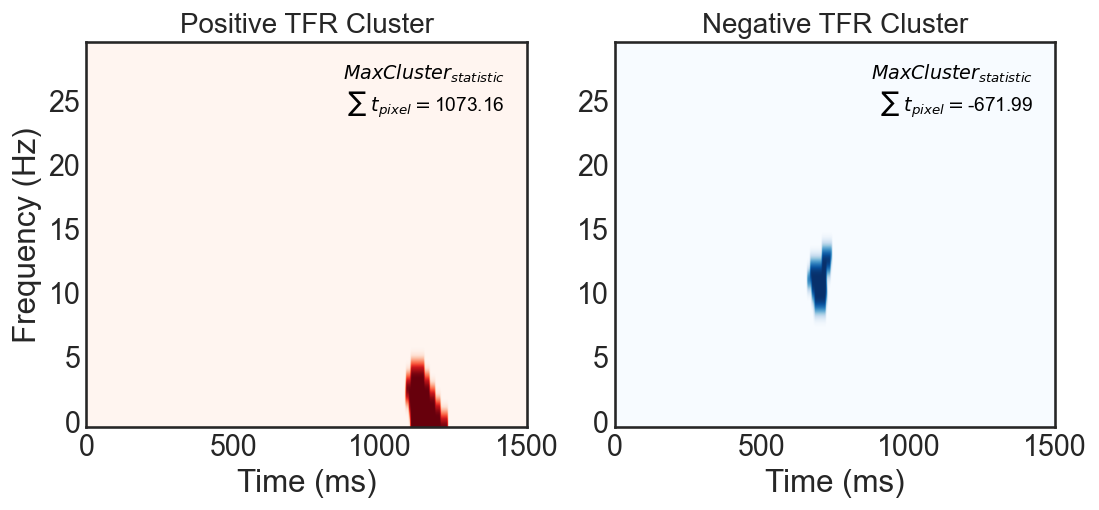

In [26]:
plot_max_clusters(cluster_test,tstats,alternative='two-sided',figsize=(10,4),dpi=125,sns_context='talk')

If I set `alternative == 'greater'`, I can just plot the largest positive cluster.

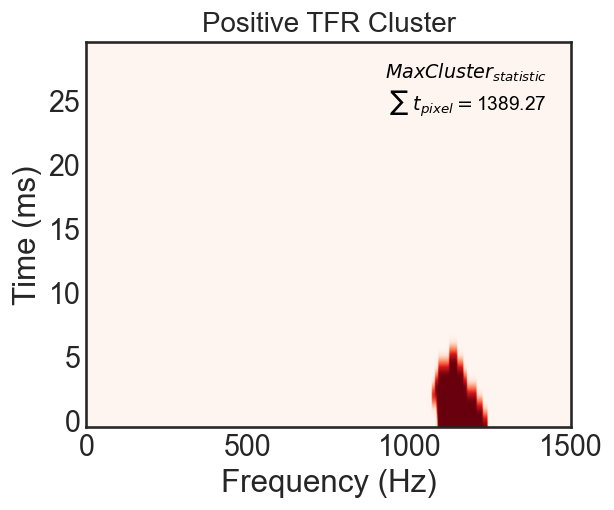

In [27]:
plot_max_clusters(cluster_test,tstats,alternative='greater',figsize=(5,4),dpi=125,sns_context='talk')


Comparatively, if I set `alternative == 'less'`, I can just plot the largest negative cluster.

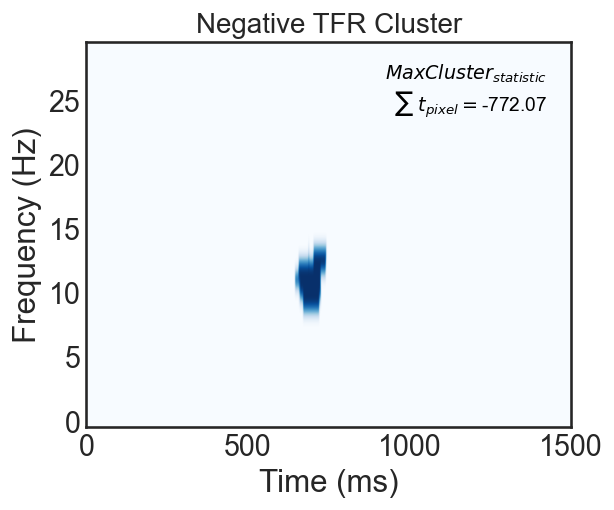

In [28]:
plot_max_clusters(cluster_test,tstats,alternative='less',figsize=(5,4),dpi=125,sns_context='talk')

## Step 3: Permute data and compute null distribution of cluster statistics.

At this point, we have computed the true cluster statistics from our neural (`tfr_data`) and behavioral data (`predictor_data`, `permute_var`). Next, we will permute our input data and re-run the cluster identification procedure on each permuted dataset. This will allow us to generate a null distribution of cluster statistics, which we can use to evaluate the statistical significance of the cluster statistics observed in our true data.

`compute_null_cluster_stats()` takes `num_permutations` as an input, which specifies the desired number of permutations. The function will permute the regressor of interest according to this number. It returns a list of null cluster statistics, with the length of the list depending on the tails of the test.

In [40]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

4089.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4089.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


We will compute the **p-value** associated with our true cluster statistics based on the null distributions we create using `cluster_significance_test()`.

In [44]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 
print(f'Positive cluster p-value: {cluster_pvalue[0]}')
print(f'Negative cluster p-value: {cluster_pvalue[1]}')

Positive cluster p-value: 0.2
Negative cluster p-value: 0.1


Let's create a plot showing the null distribution(s) we generated, with our true cluster statistic overlaid on top.

In [5]:
plot_null_distribution(null_cluster_distribution, max_cluster_data,cluster_pvalue)

NameError: name 'null_cluster_distribution' is not defined

#### POLISHED WORKFLOW

In [ ]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR. Determine which t-statistics are significant based on the critical t-value and save a thresholded t-statistic matrix.
betas, tstats = cluster_test.tfr_regression()
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats)

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution,alpha=0.05) #compute_cluster_pvalue cluster_significance_test

# Let's plot all the steps together and save the figures to a dictory that corresponds to the channel and predictor of interest. 
beta_plot,tstat_plot,cluster_plot,max_cluster_plot,null_distribution_plot = plot_neurocluster_results(betas,cluster_test, max_cluster_data, null_cluster_distribution, tstats, tstat_threshold,cluster_pvalue)

# Create the output directory if it doesn't exist
create_directory(f'{data_dir}/{ch_name}_{permute_var}')

# Save plots to the output directory
save_plot_to_pdf(beta_plot, output_directory, 'beta_plot.png')
save_plot_to_pdf(tstat_plot, output_directory, 'tstat_plot.png')
save_plot_to_pdf(cluster_plot, output_directory, 'cluster_plot.png')
save_plot_to_pdf(max_cluster_plot, output_directory, 'max_cluster_plot.png')
save_plot_to_pdf(null_distribution_plot, output_directory, 'null_distribution_plot.png')